# Binary Classification with a Bank Dataset

## Импорт библиотек и загрузка данных

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from phik import report

from collections import Counter

from sklearn.metrics import (
    f1_score,
    make_scorer,
    roc_auc_score)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from feature_engine.imputation import CategoricalImputer
from sklearn.impute import IterativeImputer, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Загрузим файлы с тренировочной и тестовой выборкой
try:
    data_train = pd.read_csv('/Users/lena/Kaggle_Binary Classification with a Bank Dataset/train.csv')
    data_test = pd.read_csv('/Users/lena/Kaggle_Binary Classification with a Bank Dataset/test.csv')
except:
    data_train = pd.read_csv('https://www.kaggle.com/competitions/playground-series-s5e8/data?select=train.csv')
    data_test = pd.read_csv('https://www.kaggle.com/competitions/playground-series-s5e8/data?select=test.csv')

In [3]:
# Откроем датасет с тренировочной выборкой data_train
data_train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [4]:
# Откроем датасет с тестовой выборкой data_test
data_test.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


## Исследовательский анализ данных

In [5]:
# Посмотрим информацию data_train
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


Всего 18 колонок и 750000 строк

| Признак     | Описание                                                                    |
| ----------- | --------------------------------------------------------------------------- |
| `id`        | Идентификатор клиента                                                       |
| `age`       | Возраст клиента                                                             |
| `job`       | Профессия (admin, blue-collar и др.)                              |
| `marital`   | Семейное положение (married, single, divorced)                              |
| `education` | Уровень образования (primary, secondary, tertiary, unknown)                 |
| `default`   | Есть ли дефолт по кредиту (yes/no)                                          |
| `balance`   | Средний баланс на счёте                                           |
| `housing`   | Есть ли ипотека (yes/no)                                                    |
| `loan`      | Есть ли персональный кредит (yes/no)                                        |
| `contact`   | Способ связи (cellular, telephone)                                          |
| `day`       | День месяца последнего контакта                                             |
| `month`     | Месяц последнего контакта                                                   |
| `duration`  | Длительность последнего звонка (в секундах)                                 |
| `campaign`  | Количество контактов в рамках кампании с данным клиентом                    |
| `pdays`     | Дни после последней маркетинговой кампании (-1 — не контактировали ранее)  |
| `previous`  | Количество контактов до текущей кампании                                    |
| `poutcome`  | Результат предыдущей кампании (success, failure, unknown)                   |
| `y`         | Целевая переменная: подписка на депозит (yes = 1, no = 0)                   |

In [6]:
# Посмотрим информацию data_test
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 32.4+ MB


Те же колонки, что и в data_train, кроме целевого признака 'y'

In [7]:
# Проверим количество пропущенных значений
data_train.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Пропущенных значений нет

In [8]:
# Проверим наличие явных дубликатов
data_train.duplicated().sum()

np.int64(0)

Явных дубликатов нет

### Баланс классов в целевой переменной

Проверим баланс целевого признака 'y' -  подпишется ли клиент на срочный банковский депозит( 1 - да, 0 - нет)

In [9]:
data_train['y'].value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

In [10]:
# Подсчёт процентов для признака y
percentages = data_train['y'].value_counts(normalize=True) * 100
print(percentages)

y
0    87.934933
1    12.065067
Name: proportion, dtype: float64


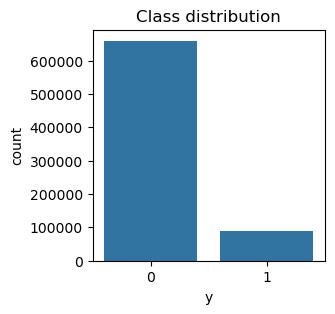

In [11]:
plt.figure(figsize=(3, 3))
sns.countplot(data=data_train, 
              x='y',
              order=data_train['y'].value_counts().index)
plt.title("Class distribution")
plt.show()

В целевой переменной наблюдается сильный дисбаланс: 87.93% значений — класс 0, и только 12.07% — класс 1. Это важно учитывать при обучении моделей, иначе они могут смещаться в сторону большинства

### Анализ числовых признаков

In [12]:
data_train.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [13]:
# Выведем общую статистическую информация о всех числовых признаках
hist_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
data_train[hist_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,750000.0,40.926395,10.098829,18.0,33.0,39.0,48.0,95.0
balance,750000.0,1204.067397,2836.096759,-8019.0,0.0,634.0,1390.0,99717.0
duration,750000.0,256.229144,272.555662,1.0,91.0,133.0,361.0,4918.0
campaign,750000.0,2.577008,2.718514,1.0,1.0,2.0,3.0,63.0
pdays,750000.0,22.412733,77.319998,-1.0,-1.0,-1.0,-1.0,871.0
previous,750000.0,0.298545,1.335926,0.0,0.0,0.0,0.0,200.0


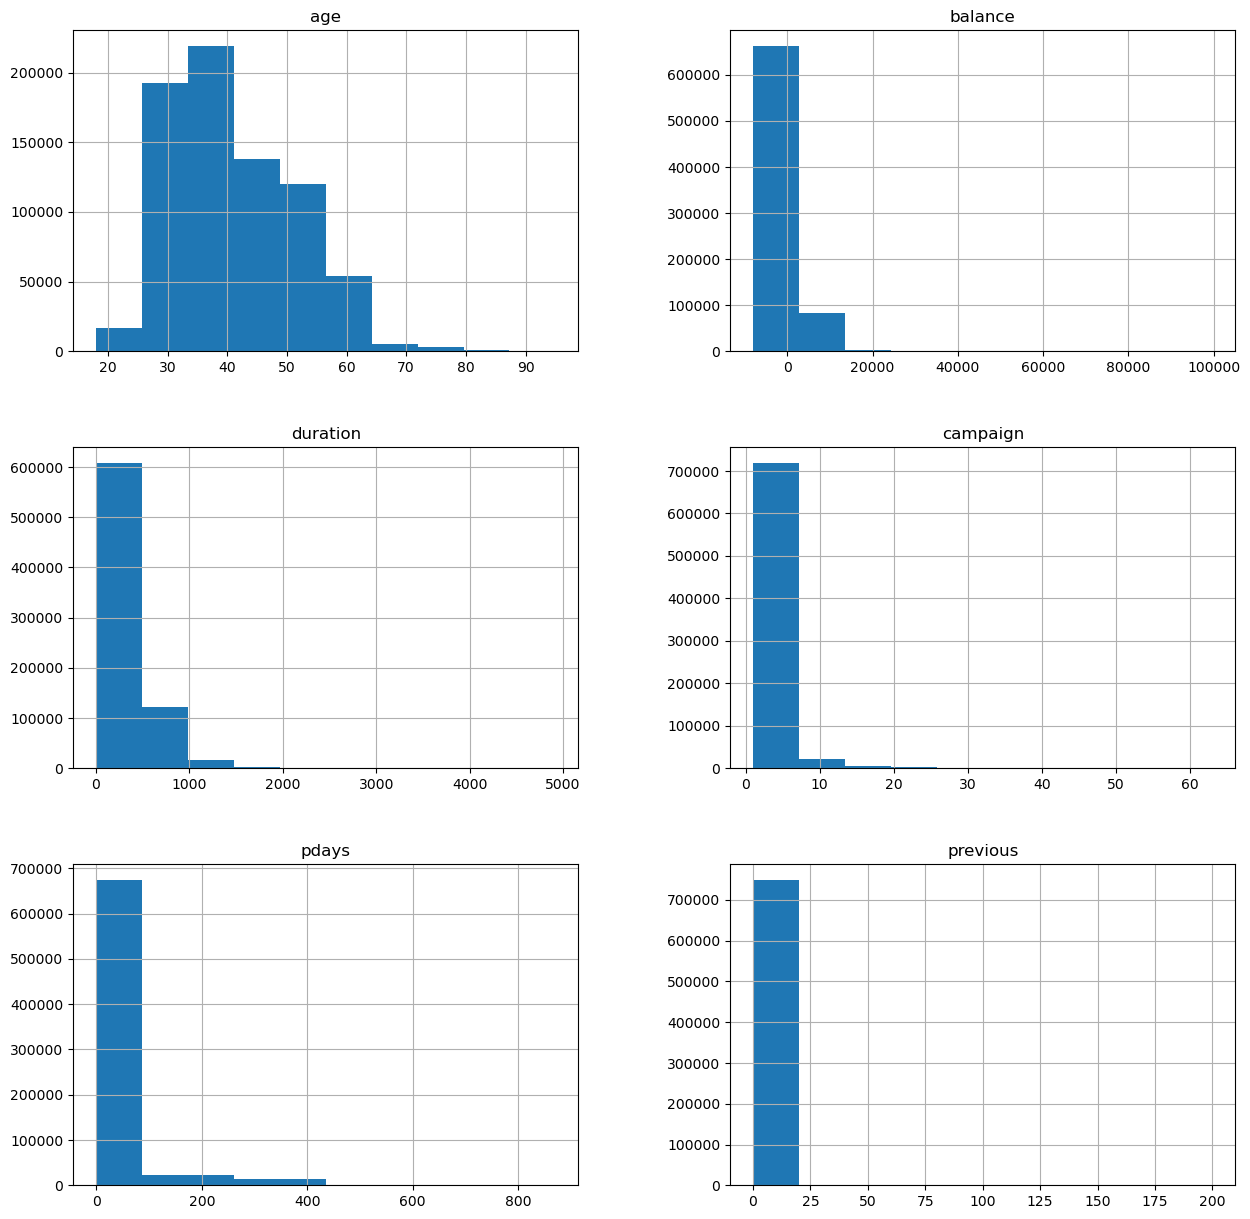

In [14]:
#Гистограмма для датасета data_train
data_train[hist_cols].hist(figsize=(15, 15));

- **Возраст (age)**
Диапазон значений: от 18 до 95 лет. Средний возраст клиента составляет 41 год.

- **Баланс (balance)**
Баланс клиента варьируется от –8019.0 до 99 717.0 (денежная единица в исходных данных не уточнена).
Среднее значение: 1204.07.
Максимальный баланс 99 717 отражает редкую, но возможную ситуацию значительных накоплений.
Отрицательные значения (до –8019) могут свидетельствовать об использовании овердрафта.

- **Длительность звонка (duration)**
Средняя длительность: 256 секунд.
Минимальное значение: 1 секунда (очень короткий контакт, возможен в реальной практике или как артефакт данных).
Максимальное значение: 4918 секунд (~1.37 часа) — редкая, но возможная ситуация продолжительного общения.

- **Количество контактов в рамках кампании (campaign)**
В среднем: ~2 звонка.
Минимум: –1 (может указывать на ошибку или кодировку данных).
Максимум: 63 звонка — редкий, но возможный случай.

- **Количество дней до следующего контакта (pdays)**
Значение –1 означает отсутствие повторного звонка; таких записей большинство.
Для остальных клиентов средний интервал составляет около 22 дней.

- **Количество контактов в предыдущих кампаниях (previous)**
В среднем: 0 звонков.
Максимальное значение: 200 звонков, что является аномально высоким, но допустимым в исходных данных.

Проанализируем, как распределены числовые признаки в зависимости от класса целевой переменной y


 Признак: age
      count       mean        std   min   25%   50%   75%   max
y                                                              
0  659512.0  40.890771   9.685370  18.0  33.0  39.0  48.0  95.0
1   90488.0  41.186036  12.709447  18.0  31.0  38.0  49.0  95.0


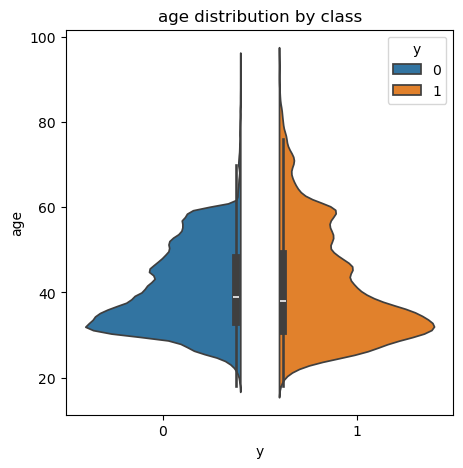


 Признак: balance
      count         mean          std     min    25%     50%     75%      max
y                                                                            
0  659512.0  1075.364679  2665.967813 -8019.0    0.0   584.0  1288.0  99717.0
1   90488.0  2142.103240  3723.617059 -8019.0  565.0  1134.0  2552.0  99218.0


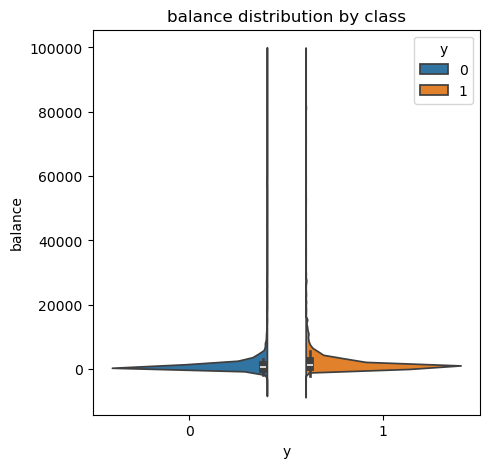


 Признак: duration
      count        mean         std  min    25%    50%    75%     max
y                                                                    
0  659512.0  203.803576  211.134874  1.0   87.0  123.0  198.0  4916.0
1   90488.0  638.327226  353.249625  1.0  358.0  609.0  855.0  4918.0


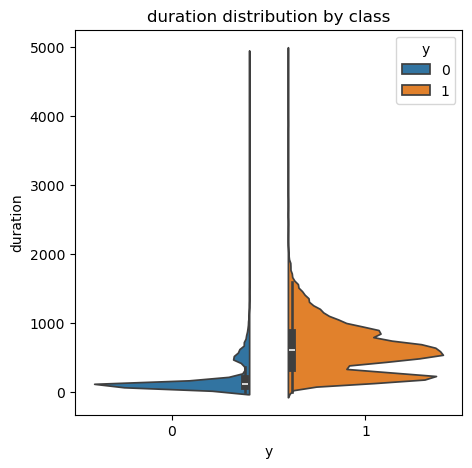


 Признак: campaign
      count      mean       std  min  25%  50%  75%   max
y                                                        
0  659512.0  2.653365  2.814649  1.0  1.0  2.0  3.0  63.0
1   90488.0  2.020489  1.777978  1.0  1.0  1.0  2.0  50.0


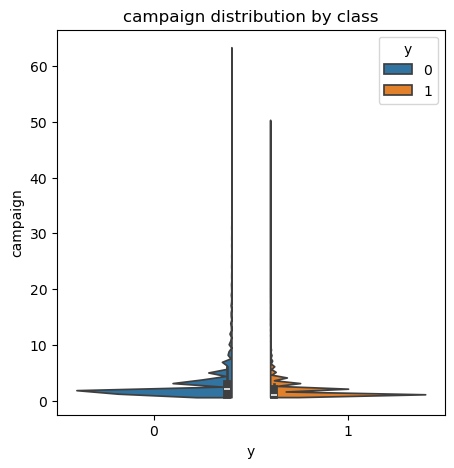


 Признак: pdays
      count       mean        std  min  25%  50%  75%    max
y                                                           
0  659512.0  19.855833  75.172523 -1.0 -1.0 -1.0 -1.0  871.0
1   90488.0  41.048426  89.276459 -1.0 -1.0 -1.0 -1.0  842.0


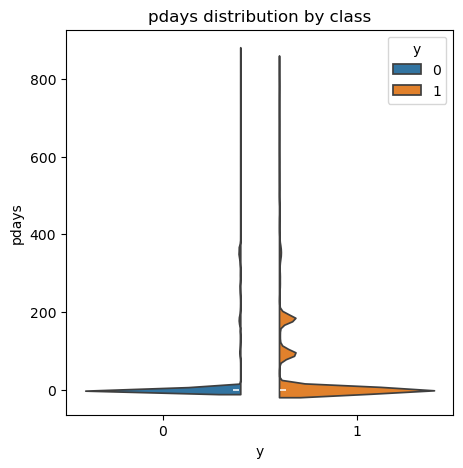


 Признак: previous
      count      mean       std  min  25%  50%  75%    max
y                                                         
0  659512.0  0.239386  1.225318  0.0  0.0  0.0  0.0  200.0
1   90488.0  0.729721  1.907375  0.0  0.0  0.0  0.0   55.0


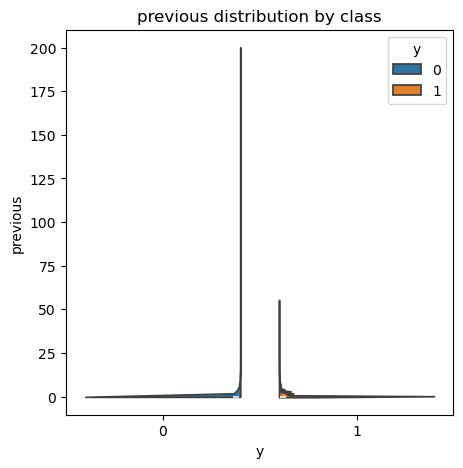

In [15]:
for col in hist_cols:
    print(f"\n Признак: {col}")

    # Описательная статистика по классам
    desc = data_train.groupby("y")[col].describe()
    print(desc)

    # Строим график
    plt.figure(figsize=(5, 5))
    sns.violinplot(
        data=data_train, x="y", y=col, hue="y", split=True, palette="tab10"
    )
    plt.title(f"{col} distribution by class")
    plt.show()

Анализ числовых признаков в разрезе классов целевой переменной (y):

- Возраст (age). Медианный возраст клиентов примерно одинаковый в обеих группах (~38–39 лет). Однако среди подписавшихся на депозит наблюдается чуть большая доля клиентов старшего возраста.

- Баланс на счёте (balance). В группе подписавшихся (y=1) медианный баланс выше (1134), чем у клиентов, не оформивших депозит (y=0, медиана 584). Это может указывать на то, что клиенты с более высокой финансовой устойчивостью чаще склонны соглашаться на депозит.

- Длительность звонка (duration). Показатель существенно различается между группами. У подписавшихся клиентов медианная длительность разговора составляет ~855 секунд, тогда как у отказавшихся — около 198 секунд. Таким образом, успешные клиенты, как правило, дольше общались с сотрудниками банка.

- Количество контактов в рамках текущей кампании (campaign). У клиентов, не подписавшихся на депозит (y=0), медианное значение чуть выше (2 контакта против 1 у y=1). Это может указывать на то, что повторные звонки не всегда повышают вероятность подписки.

- Интервал с момента последнего контакта (pdays). Значительная часть значений равна «-1» (клиенты не контактировались ранее). Если учитывать только осмысленные значения, то у подписавшихся клиентов среднее значение выше (41 день) по сравнению с отказавшимися (18 дней), что указывает на более активное взаимодействие с этой группой.

- Количество контактов в предыдущих кампаниях (previous). Для большинства клиентов этот показатель равен 0. Однако встречаются редкие экстремальные значения: максимум 200 звонков в группе y=0 и 55 звонков в группе y=1.

### Анализ категориальных признаков

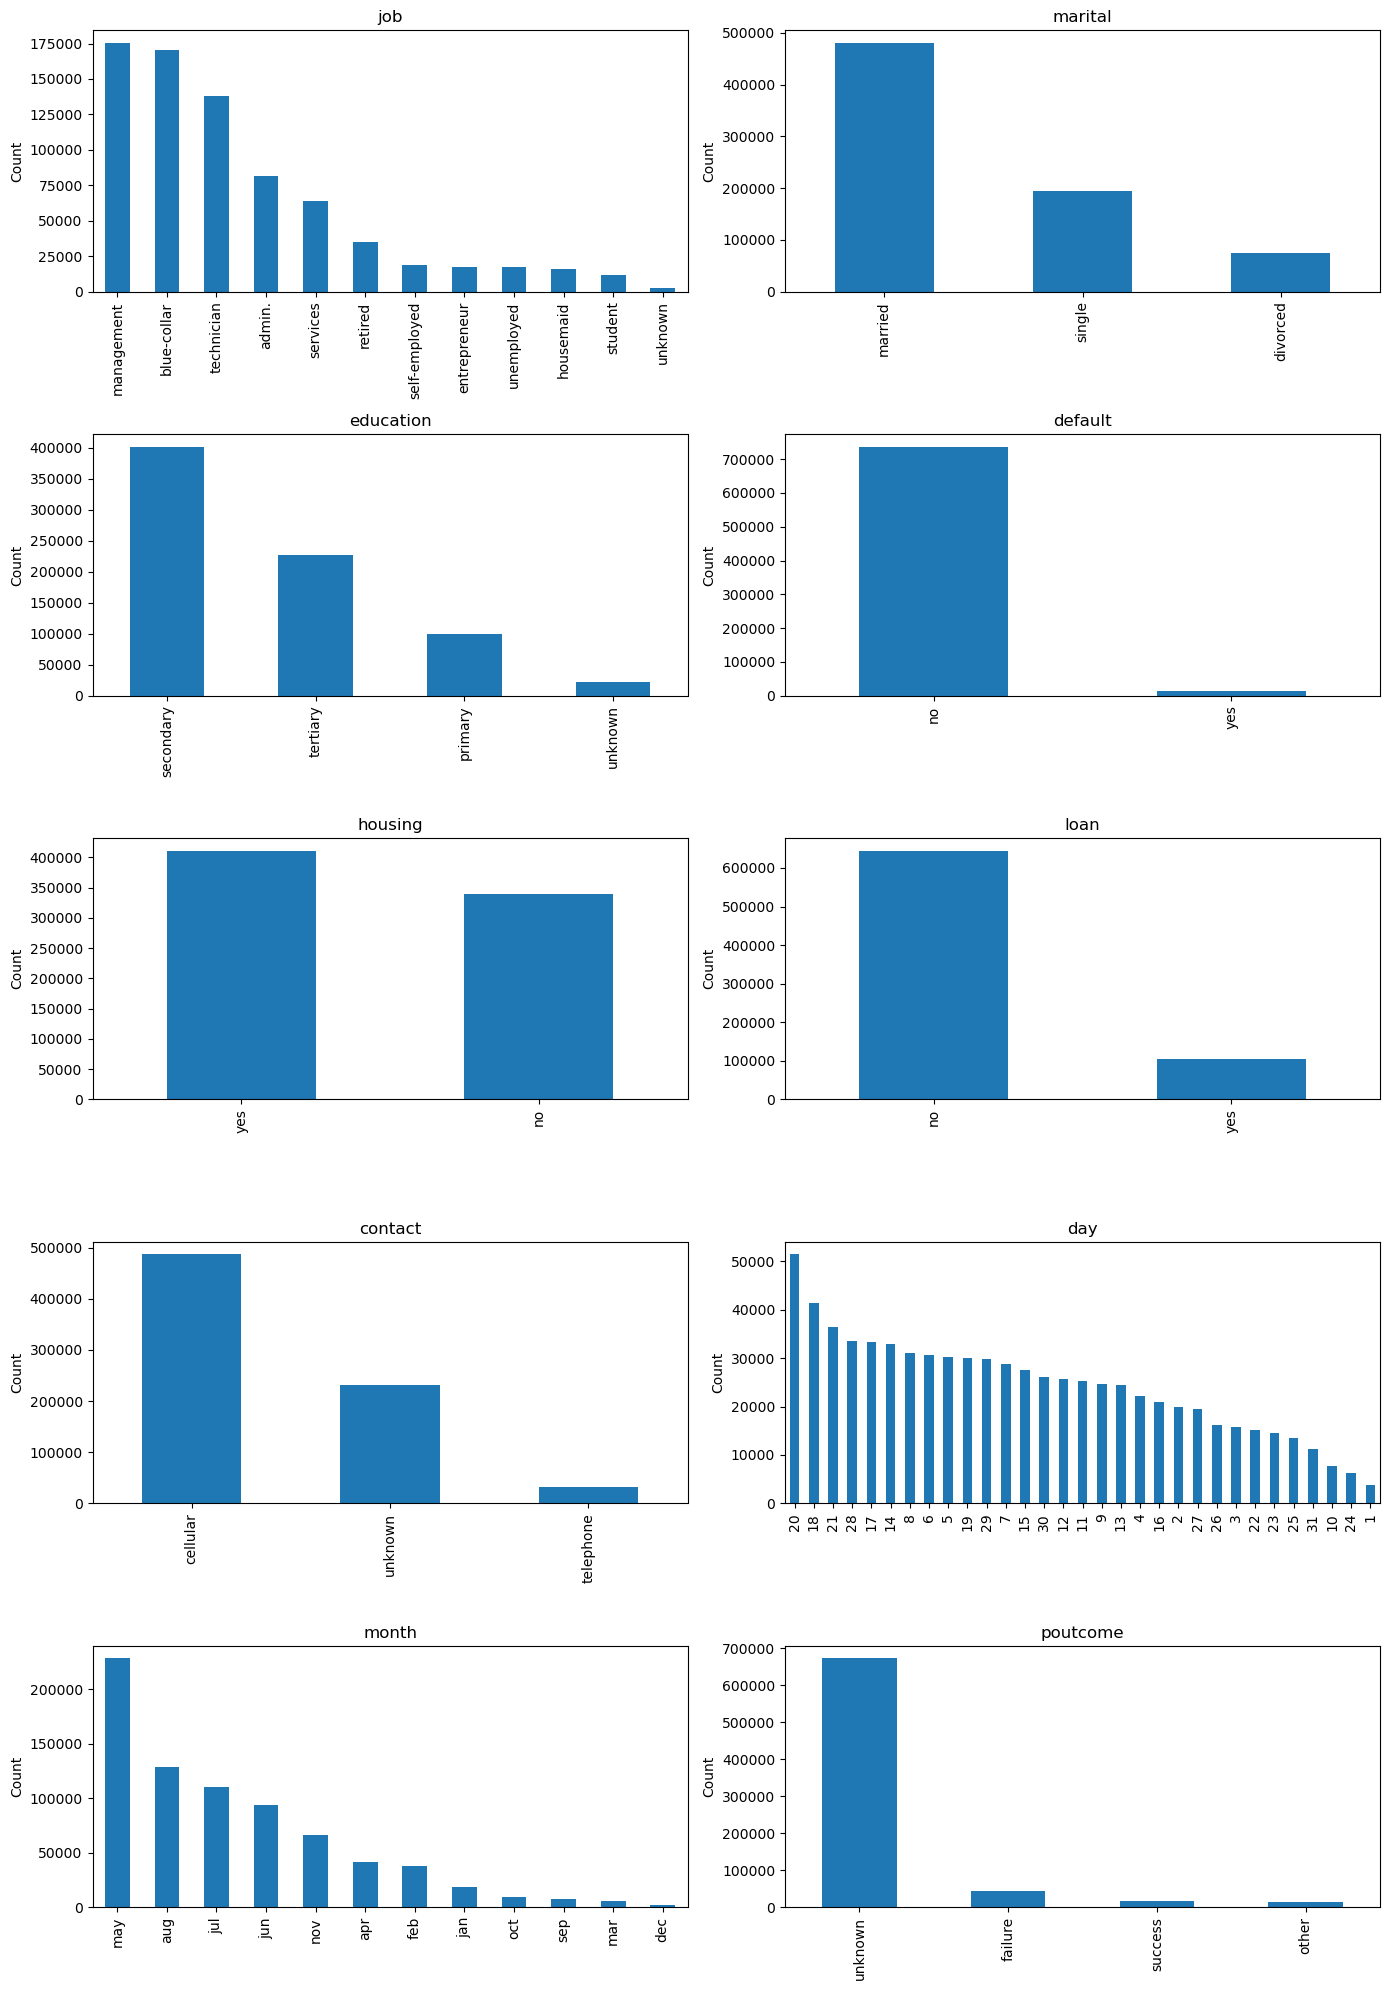

In [16]:
import matplotlib.pyplot as plt

cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
            'contact', 'day', 'month', 'poutcome']

# Размер сетки для графиков (2 колонки)
n_cols = 2
n_rows = (len(cat_cols) + 1) // n_cols

plt.figure(figsize=(14, n_rows * 4))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    data_train[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Портрет клиента данного банка:

- Наиболее часто встречаются клиенты из сфер менеджмента, рабочих профессий и технических специальностей.

- Большая часть клиентов состоит в браке.

- Преобладающий уровень образования — среднее (secondary).

- В большинстве случаев клиенты не имеют дефолта по кредиту, часто имеют ипотеку, но при этом реже пользуются личными кредитами.

- Основной способ связи — мобильная связь.

- День месяца последнего контакта чаще всего приходится на 20-е число.

- Месяц последнего контакта — преимущественно май.

- В подавляющем большинстве случаев результат предыдущей кампании был неизвестен (unknown); из имеющихся данных преобладают кампании с результатом failure


Рассмотрим распределение категориальных признаков в разрезе классов целевой переменной y.


 Признак: job
y                   0      1   total  conversion_rate
job                                                  
student          7757   4010   11767         0.340784
retired         26521   8664   35185         0.246241
unemployed      14463   3171   17634         0.179823
management     149141  26400  175541         0.150392
self-employed   16558   2462   19020         0.129443
unknown          2565    352    2917         0.120672
technician     121766  16341  138107         0.118321
admin.          72002   9490   81492         0.116453
housemaid       14565   1347   15912         0.084653
services        58898   5311   64209         0.082714
entrepreneur    16276   1442   17718         0.081386
blue-collar    159000  11498  170498         0.067438


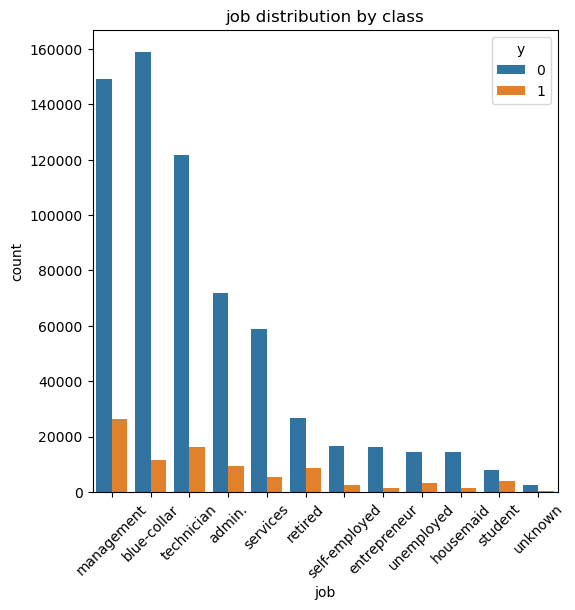


 Признак: marital
y              0      1   total  conversion_rate
marital                                         
single    161624  33210  194834         0.170453
divorced   66105   8302   74407         0.111576
married   431783  48976  480759         0.101872


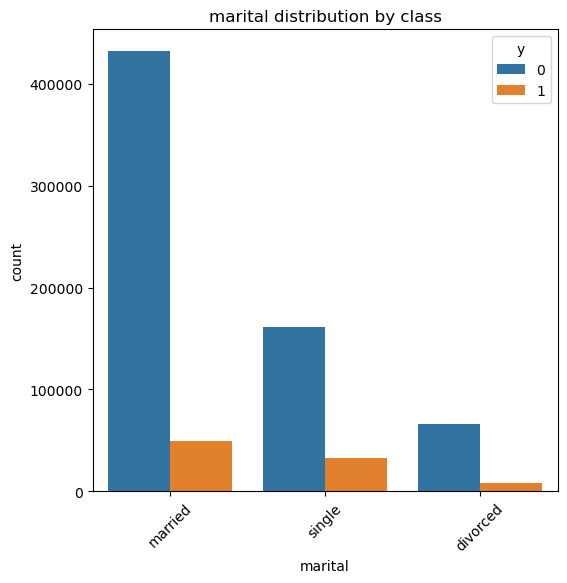


 Признак: education
y               0      1   total  conversion_rate
education                                        
tertiary   190504  37004  227508         0.162649
unknown     18458   2841   21299         0.133387
secondary  359309  42374  401683         0.105491
primary     91241   8269   99510         0.083097


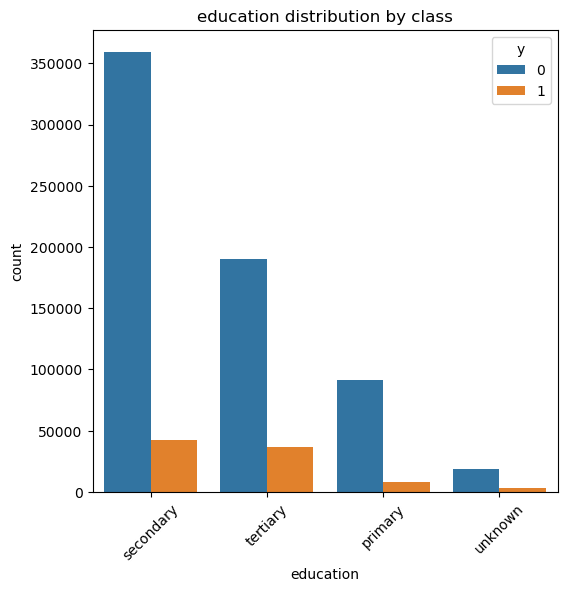


 Признак: default
y             0      1   total  conversion_rate
default                                        
no       647258  89893  737151         0.121947
yes       12254    595   12849         0.046307


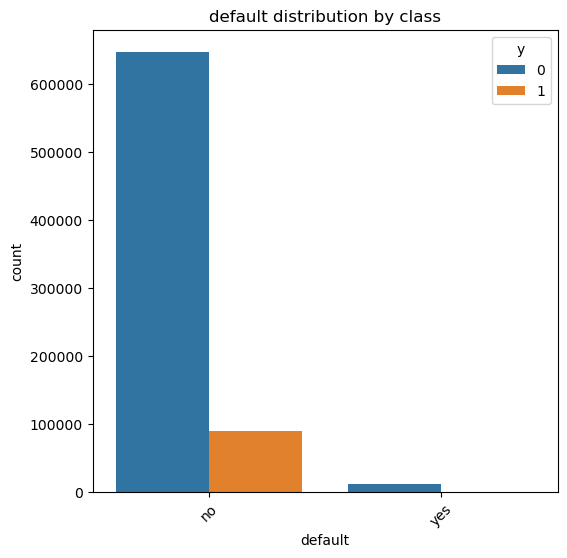


 Признак: housing
y             0      1   total  conversion_rate
housing                                        
no       279174  59538  338712         0.175778
yes      380338  30950  411288         0.075251


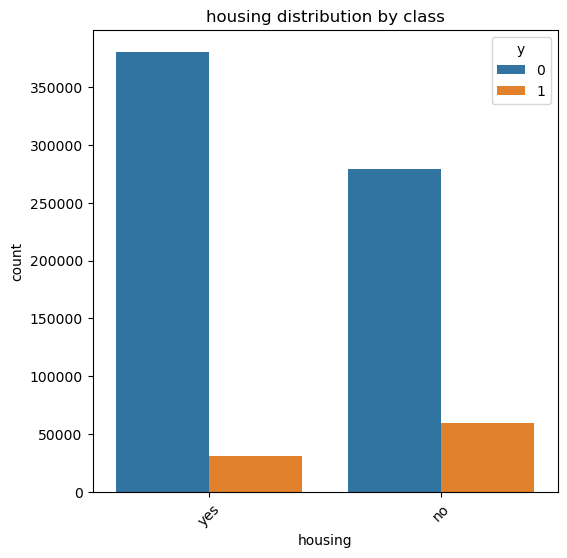


 Признак: loan
y          0      1   total  conversion_rate
loan                                        
no    560281  84742  645023         0.131378
yes    99231   5746  104977         0.054736


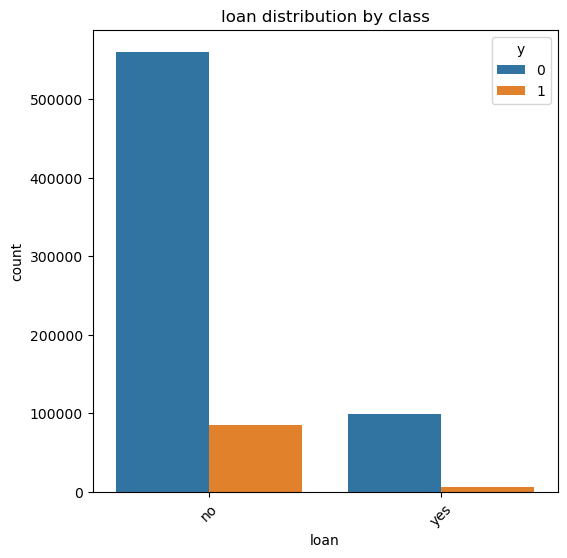


 Признак: contact
y               0      1   total  conversion_rate
contact                                          
cellular   410455  76200  486655         0.156579
telephone   27379   4339   31718         0.136799
unknown    221678   9949  231627         0.042953


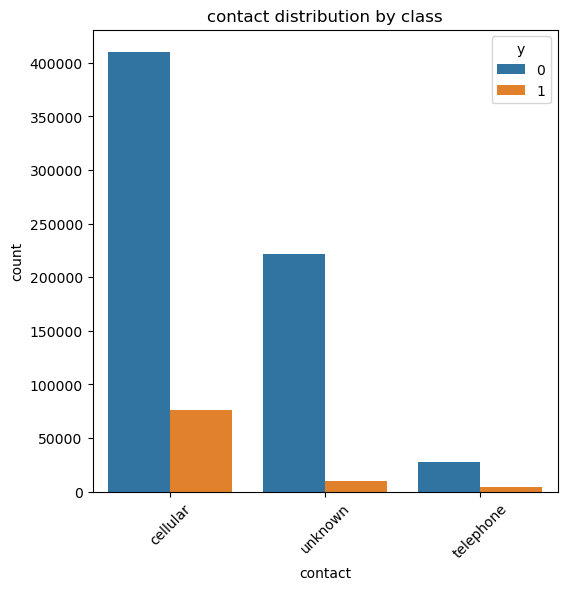


 Признак: day
y        0     1  total  conversion_rate
day                                     
1     2497  1393   3890         0.358098
10    5809  1817   7626         0.238264
30   20683  5498  26181         0.210000
3    12595  3232  15827         0.204208
4    18128  4142  22270         0.185990
12   21084  4538  25622         0.177113
2    16496  3507  20003         0.175324
13   20406  4082  24488         0.166694
22   12678  2450  15128         0.161951
16   17785  3124  20909         0.149409
15   23566  3936  27502         0.143117
24    5369   872   6241         0.139721
25   11650  1842  13492         0.136525
5    26233  4012  30245         0.132650
23   12619  1920  14539         0.132059
11   21985  3254  25239         0.128927
14   29151  3703  32854         0.112711
27   17443  2143  19586         0.109415
8    27699  3297  30996         0.106369
26   14515  1701  16216         0.104896
9    22177  2575  24752         0.104032
18   37207  4145  41352         0.100237
1

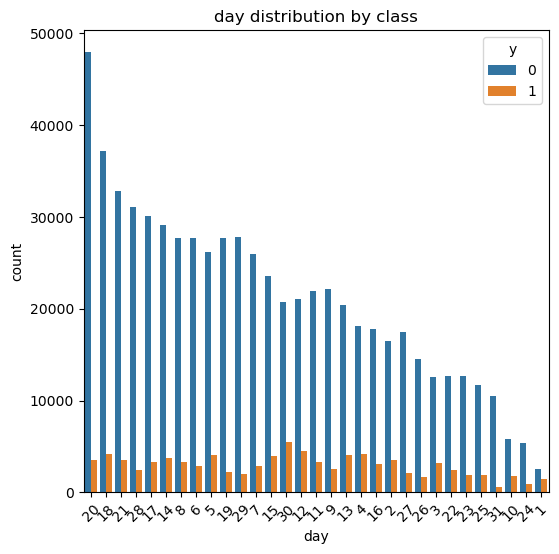


 Признак: month
y           0      1   total  conversion_rate
month                                        
mar      2487   3315    5802         0.571355
sep      3447   3962    7409         0.534755
dec      1007   1062    2069         0.513291
oct      4694   4510    9204         0.490004
apr     31582   9737   41319         0.235654
feb     29833   7778   37611         0.206801
jan     16586   2351   18937         0.124148
aug    114406  14453  128859         0.112161
nov     58808   7254   66062         0.109806
jun     83954   9716   93670         0.103726
jul    100595  10052  110647         0.090847
may    212113  16298  228411         0.071354


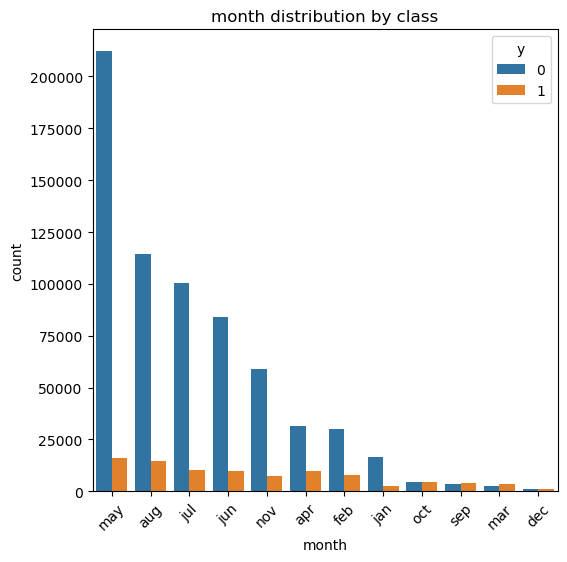


 Признак: poutcome
y              0      1   total  conversion_rate
poutcome                                        
success     4175  13516   17691         0.764004
other      12284   2460   14744         0.166848
failure    39124   5991   45115         0.132794
unknown   603929  68521  672450         0.101898


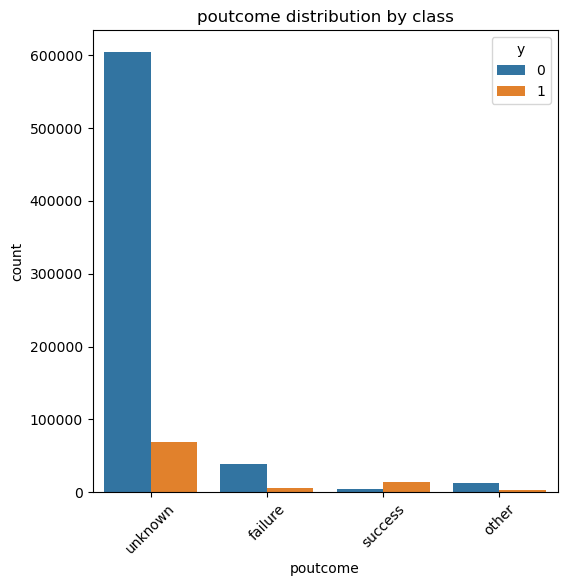

In [17]:
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 
            'day', 'month', 'poutcome']

for col in cat_cols:
    print(f"\n Признак: {col}")
    
    # Разбивка по классам
    counts = pd.crosstab(data_train[col], data_train['y'])
    counts["total"] = counts.sum(axis=1)
    counts["conversion_rate"] = counts[1] / counts["total"]
    
    print(counts.sort_values("conversion_rate", ascending=False))
    
    # Визуализация (оставляем как было)
    plt.figure(figsize=(6, 6))
    sns.countplot(
        data=data_train, 
        x=col, 
        hue="y", 
        order=data_train[col].value_counts().index
    )
    plt.title(f"{col} distribution by class")
    plt.xticks(rotation=45)
    plt.show()

- Профессия (job)

    - Наибольшая конверсия наблюдается среди студентов (≈34%) и пенсионеров (≈25%).
    - Наименьшая — среди работников физического труда (≈6.7%) и предпринимателей (≈8.1%).
Клиенты без профессии чаще соглашаются на депозит.

- Семейное положение (marital)

    - Наибольшая конверсия у холостых (≈17%).
    - Наименьшая — у состоящих в браке (≈10%).
Семейное положение оказывает влияние на вероятность согласия на депозит.

- Образование (education)

    - Наибольшая конверсия у клиентов с высшим образованием (≈16%).
    - Наименьшая — у клиентов с начальным уровнем образования (≈8%).
Более высокий уровень образования положительно коррелирует с откликом.

- Есть ли дефолт по кредиту (default)

    - У клиентов без дефолта конверсия составляет ≈12%.
    - У клиентов с дефолтом — только ≈4.6%.

- Есть ли ипотека (housing)

    - Без ипотеки конверсия ≈17.5%.
    - С ипотекой — ≈7.5%.
Наличие ипотеки снижает вероятность отклика.

- Есть ли персональный кредит (loan)

    - Без кредита конверсия ≈13%.
    - С кредитом — ≈5.5%.
Наличие кредита также снижает вероятность отклика.

- Способ связи (contact)

Наиболее высокая конверсия у клиентов, с которыми контактировали по мобильной связи (≈15.7%).

- День месяца последнего контакта (day)

    - Наибольшая конверсия у клиентов, контактированных 1-го числа месяца (≈36%).
    - Наименьшая — ближе к концу месяца (≈5.5–7%).
День контакта оказывает заметное влияние на вероятность отклика.

- Месяц последнего контакта (month)

    - Высокая конверсия наблюдается в марте, сентябре и декабре (≈51–57%).
    - Низкая — в мае (≈7%).

- Результат предыдущей кампании (poutcome)

Наибольшая конверсия у клиентов, имевших успех в предыдущей кампании (≈76%).
История предыдущего контакта является значимым фактором.

Заменим бинарные значения 'yes'/'no' на 1/0

In [18]:
cols_to_replace = ['default', 'housing', 'loan']

data_train[cols_to_replace] = data_train[cols_to_replace].replace({'yes': 1, 'no': 0})
data_test[cols_to_replace] = data_test[cols_to_replace].replace({'yes': 1, 'no': 0})

In [19]:
data_train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,0,7,0,0,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,0,514,0,0,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,0,602,1,0,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,0,34,1,0,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,0,889,1,0,cellular,3,feb,902,1,-1,0,unknown,1


In [20]:
data_test.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,0,1397,1,0,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,0,23,1,0,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,0,46,1,1,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,0,-1380,1,1,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,0,1950,1,0,cellular,22,jul,181,1,-1,0,unknown


Заменим названия месяцев на числа

In [21]:
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

data_train['month'] = data_train['month'].map(month_map)
data_test['month'] = data_test['month'].map(month_map)

### Вывод

- **Дисбаланс целевой переменной**
Целевая переменная имеет выраженный дисбаланс: 87.93% клиентов отказались от депозита, и только 12.07% согласились. Это важно учитывать при обучении моделей, чтобы избежать смещения прогнозов в сторону большинства.

- **Числовые признаки**

    - Возраст. Подписавшиеся клиенты чаще относятся к старшим возрастным группам.

    - Баланс. Более высокий баланс положительно коррелирует с вероятностью открытия депозита.

    - Длительность звонка. Это один из ключевых факторов: клиенты, согласившиеся на депозит, имеют в несколько раз более длительные контакты.

    - Количество контактов. Повторные звонки не всегда повышают вероятность успеха, а иногда даже снижают её.

    - Pdays. Более длинный интервал между контактами характерен для согласившихся клиентов.

- **Категориальные признаки**

    - Профессия. Наибольшая конверсия у студентов и пенсионеров, наименьшая — у рабочих и предпринимателей.

    - Семейное положение. Холостые чаще соглашаются, чем состоящие в браке.

    - Образование. Более высокий уровень образования увеличивает вероятность отклика.

    - Финансовые обязательства. Наличие дефолта, ипотеки или кредита снижает вероятность согласия.

    - Канал связи. Наиболее результативный канал — мобильная связь.

    - Время контакта. Конверсия зависит от даты: в начале месяца и в отдельных месяцах (март, сентябрь, декабрь) вероятность выше, в мае — минимальная.

    - История предыдущей кампании. Самый сильный предиктор: успех в прошлой кампании многократно повышает шансы согласия (≈76%).

- **Портрет клиента, наиболее склонного открыть депозит**
Среди наиболее отзывчивых клиентов выделяются две основные группы:
    - студенты — демонстрируют наибольшую конверсию;
    - пенсионеры и клиенты старшего возраста — также чаще соглашаются на депозит.
Кроме того, положительно на вероятность согласия влияют:
    - стабильный положительный баланс;
    - отсутствие дефолта и кредитных обязательств;
    - более высокий уровень образования.
      
Наибольшая вероятность отклика наблюдается при контакте по мобильной связи, особенно в начале месяца, а также в случае успешного опыта участия клиента в предыдущих кампаниях.

## Создание новых признаков (Feature engineering)

Создадим несколько новых признаков

In [22]:
# Новые признаки на основе 'Duration'
#  log(duration)

data_train['duration_log'] = np.log1p(data_train['duration'])
data_test['duration_log'] = np.log1p(data_test['duration'])

#  duration per campaign
data_train['duration_per_campaign'] = data_train['duration'] / (data_train['campaign'] + 1)
data_test['duration_per_campaign'] = data_test['duration'] / (data_test['campaign'] + 1)

#  duration bins
def duration_bin(df):
    # границы интервалов адаптируем под твою статистику
    bins = [0, 60, 150, 360, df['duration'].max()+1]  # short, medium_short, medium_long, long
    labels = ['short', 'medium_short', 'medium_long', 'long']
    df['duration_bin'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False)
    return df

data_train = duration_bin(data_train)
data_test = duration_bin(data_test)

In [23]:
# Взаимодействия числовых признаков
# balance / age
data_train['balance_per_age'] = data_train['balance'] / (data_train['age'] + 1)
data_test['balance_per_age'] = data_test['balance'] / (data_test['age'] + 1)

# campaign * previous
data_train['campaign_prev'] = data_train['campaign'] * data_train['previous']
data_test['campaign_prev'] = data_test['campaign'] * data_test['previous']

In [24]:
data_train.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,...,campaign,pdays,previous,poutcome,y,duration_log,duration_per_campaign,duration_bin,balance_per_age,campaign_prev
0,0,42,technician,married,secondary,0,7,0,0,cellular,...,3,-1,0,unknown,0,4.770685,29.250000,medium_short,0.162791,0
1,1,38,blue-collar,married,secondary,0,514,0,0,unknown,...,1,-1,0,unknown,0,5.225747,92.500000,medium_long,13.179487,0
2,2,36,blue-collar,married,secondary,0,602,1,0,unknown,...,2,-1,0,unknown,0,4.718499,37.000000,medium_short,16.270270,0
3,3,27,student,single,secondary,0,34,1,0,unknown,...,2,-1,0,unknown,0,2.397895,3.333333,short,1.214286,0
4,4,26,technician,married,secondary,0,889,1,0,cellular,...,1,-1,0,unknown,1,6.805723,451.000000,long,32.925926,0


In [25]:
data_test.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,...,duration,campaign,pdays,previous,poutcome,duration_log,duration_per_campaign,duration_bin,balance_per_age,campaign_prev
0,750000,32,blue-collar,married,secondary,0,1397,1,0,unknown,...,224,1,-1,0,unknown,5.416100,112.000000,medium_long,42.333333,0
1,750001,44,management,married,tertiary,0,23,1,0,cellular,...,586,2,-1,0,unknown,6.375025,195.333333,long,0.511111,0
2,750002,36,self-employed,married,primary,0,46,1,1,cellular,...,111,2,-1,0,unknown,4.718499,37.000000,medium_short,1.243243,0
3,750003,58,blue-collar,married,secondary,0,-1380,1,1,unknown,...,125,1,-1,0,unknown,4.836282,62.500000,medium_short,-23.389831,0
4,750004,28,technician,single,secondary,0,1950,1,0,cellular,...,181,1,-1,0,unknown,5.204007,90.500000,medium_long,67.241379,0


## Проверка значений на мультиколлинеарность

Будем использовать phik, так как он позволяет обнаружить корреляцию не только между количественными, но и между качественными признаками

interval columns not set, guessing: ['age', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'y', 'duration_log', 'duration_per_campaign', 'balance_per_age', 'campaign_prev']


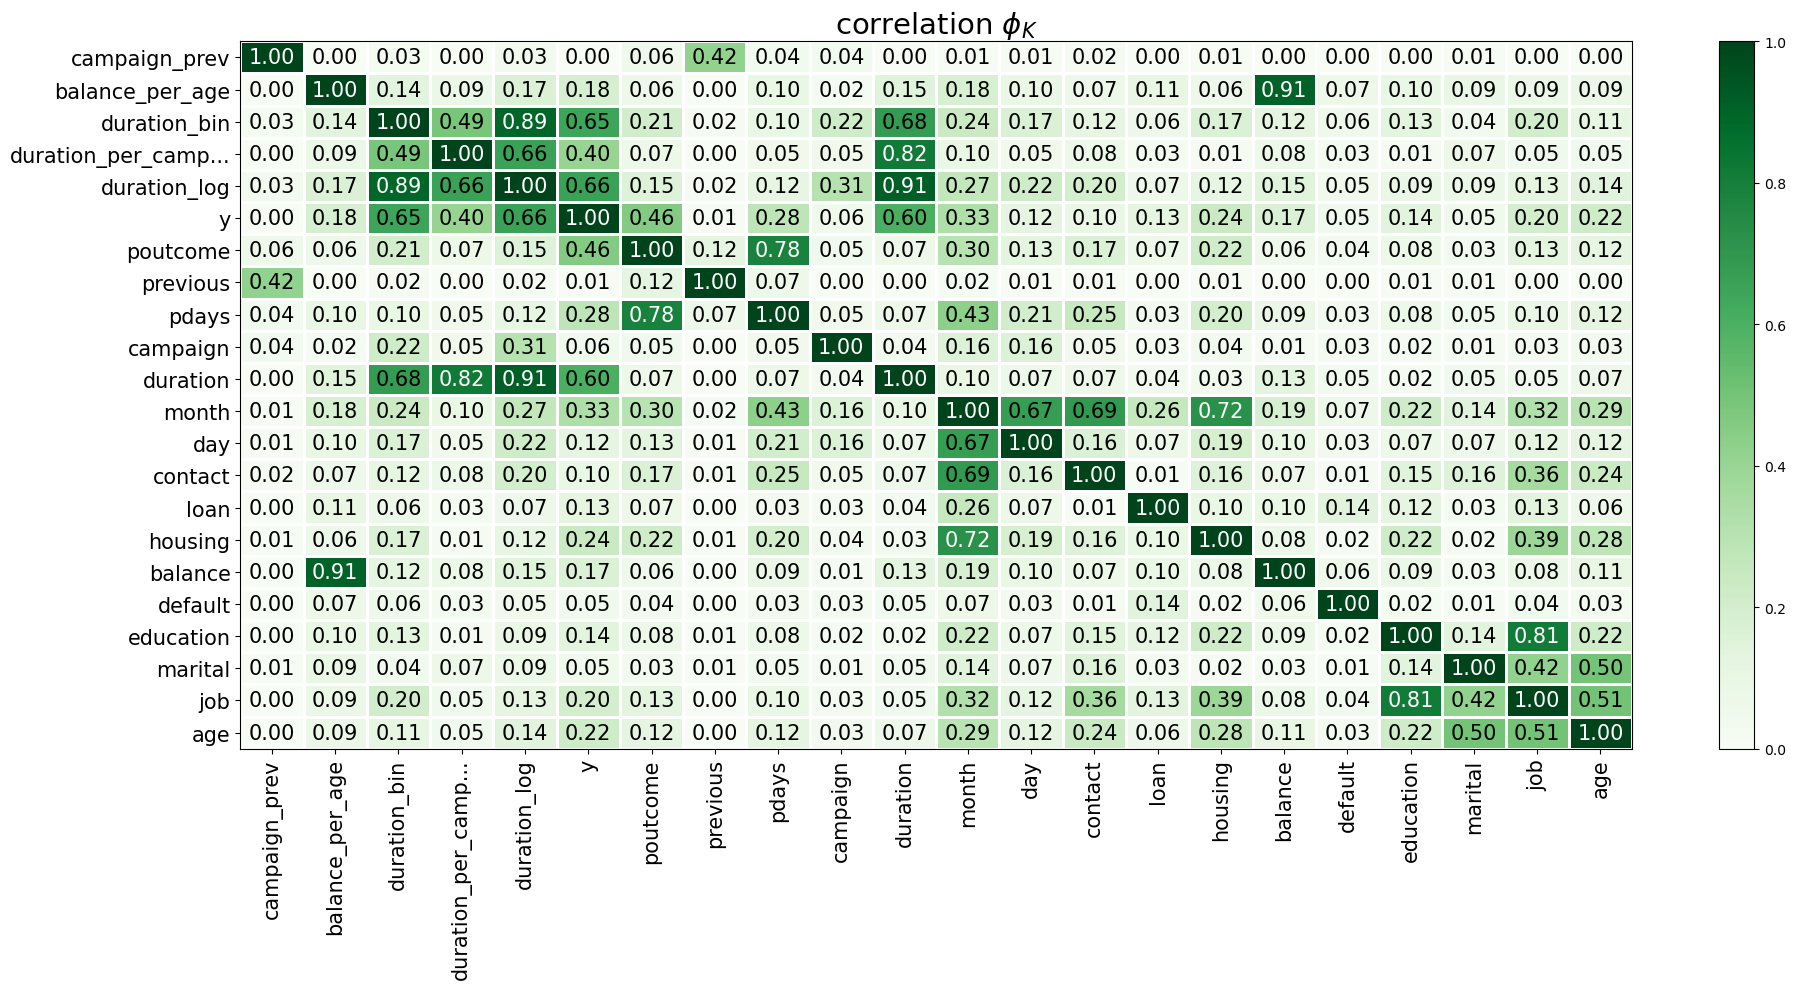

In [26]:
# Удалим 'id', чтобы не усложнять обработку данных

data_temp = data_train.drop(['id'], axis=1)

phik_overview = data_temp.phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 10))
plt.tight_layout();

Обнаружена корреляция между признаками:

- balance_per_age и balance (0.91)
- duration_log и duration (0.91)
- duration_log и duration_bin (0.89)
- duration_per_campaign и duration (0.82)
- job и education (0.81)

Для логистической регрессии высокие корреляции могут вызвать мультиколлинеарность, что приведёт к нестабильным коэффициентам и снижению интерпретируемости модели. Поэтому лучше удалить дублирующие признаки.

Для деревьев решений и градиентных моделей мультиколлинеарность менее критична, модели сами выбирают важные признаки. Поэтому для них можно оставить все признаки, чтобы модель использовала всю доступную информацию.

## Проверка важности признаков (Mutual Information)

Дополнительно проверим важность признаков (Mutual Information) до обучения моделей, чтобы понять, какие признаки потенциально несут полезную информацию о таргете ещё до запуска сложных алгоритмов.

- Измеряет, насколько знание признака уменьшает неопределённость таргета.
- Работает и с нелинейными зависимостями, и с категориальными признаками. Иногда Mutual Information выделяет признаки, которые не линейно влияют на таргет, и которые классические корреляции не видят.
- Помогает определить признаки, которые не несут полезной информации о целевой переменной

duration_log             0.155279
duration                 0.154894
duration_per_campaign    0.145497
housing                  0.120088
duration_bin             0.103642
balance                  0.069838
balance_per_age          0.059530
month                    0.052599
pdays                    0.029308
poutcome                 0.027718
campaign                 0.024772
age                      0.018700
contact                  0.015029
day                      0.013956
loan                     0.012201
previous                 0.011897
campaign_prev            0.011636
job                      0.011160
education                0.003906
marital                  0.003894
default                  0.000736
dtype: float64


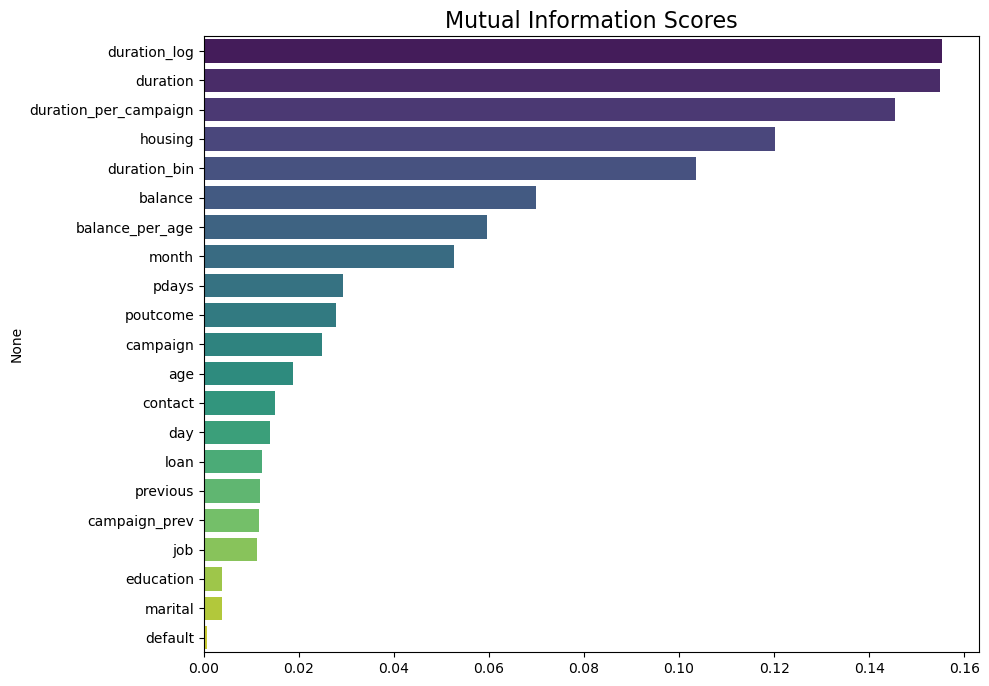

In [27]:
target_col = 'y'
cat_cols = ['job', 'marital', 'education', 'contact', 'poutcome', 'duration_bin']
df_enc = data_train.copy()

exclude_cols = [target_col, 'id']
all_features = [c for c in df_enc.columns if c not in exclude_cols]

# Кодируем категориальные признаки
for col in cat_cols:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col].astype(str))

# Кодируем таргет
le = LabelEncoder()
y_encoded = le.fit_transform(df_enc[target_col])

# Указываем дискретные признаки
discrete_features = [col in cat_cols for col in all_features]

# Mutual Information
mi = mutual_info_classif(
    df_enc[all_features],
    y_encoded,
    discrete_features=discrete_features
)

mi_series = pd.Series(mi, index=all_features).sort_values(ascending=False)
print(mi_series)

plt.figure(figsize=(10, 8))
sns.barplot(x=mi_series.values, y=mi_series.index, palette="viridis")
plt.title("Mutual Information Scores", fontsize=16)
plt.show()

Наиболее значимые признаки:
- duration_log             
- duration                 
- duration_per_campaign    
- housing                  
- duration_bin             

Менее информативный признак: 
- default

In [28]:
data_train.duplicated().sum()

np.int64(0)

## Отбор признаков

Для всех моделей исключим менее информативный признак 

- id
- default

Для логистической регрессии удалим дополнительно коррелирующие признаки: 

- balance_per_age
- duration_log
- duration_per_campaign
- job

## Обучение моделей с использованием Pipeline и GridSearchCV

Предстоит решить задачу бинарной классификации:

Предсказать, будет ли клиент подписаться на банковский депозит (1 - да, 0 - нет)

Обучим 3 модели с помощью облегченной версии Pipeline и GridSearchCV:

- LogisticRegression
- CatBoostClassifier
- XGBClassifier

Для оценки качества будем использовать метрику **ROC AUC** (Receiver Operating Characteristic curve) — кривая, которая показывает, как модель различает два класса (например, да/нет).

    - False Positive Rate, FPR — доля ложно-положительных ошибок (когда предсказали 1, а на самом деле 0).
    - True Positive Rate, TPR, Recall — доля правильно найденных "да" - 1.

Модель возвращает вероятности принадлежности к классу (0.5, 0.3, 0.7 и т. д.)

Построим Pipeline с перебором гиперпараметров через GridSearchCV для оптимизации модели.
Добавим балансировку классов по таргету с помощью параметра class_weight='balanced', чтобы модели учитывали дисбаланс между положительными и отрицательными примерами.

In [29]:
# Разделим признаки на числовые, категориальные и таргет

numeric_cols = [
    'age', 'balance', 'housing', 'loan', 'day', 'month', 'campaign', 'duration',
    'pdays', 'previous', 'balance_per_age', 'campaign_prev',
    'duration_log', 'duration_per_campaign'
]
categorical_cols = ['job', 'marital', 'education', 'contact', 'poutcome', 'duration_bin']
target_col = 'y'

X = data_train[numeric_cols + categorical_cols]
y = data_train[target_col]

# Базовые трансформеры

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Препроцессор для всех моделей, кроме Logistic Regression
preprocessor_full = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Урезанный препроцессор для Logistic Regression
numeric_cols_lr = [col for col in numeric_cols if col not in ['balance_per_age', 
                                                              'duration_log', 
                                                              'duration_per_campaign']]
categorical_cols_lr = [col for col in categorical_cols if col not in ['job']]

preprocessor_lr = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols_lr),
    ('cat', categorical_transformer, categorical_cols_lr)
])

# Модели с пайплайном и гиперпараметрами

models = {
    "Logistic Regression": (Pipeline([
        ('preprocessor', preprocessor_lr),
        ('model', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
    ]), {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs']
    }),
    
    "CatBoostClassifier": (Pipeline([
        ('preprocessor', preprocessor_full),
        ('model', CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced'))
    ]), {
        'model__iterations': [100, 200],
        'model__depth': [6, 8],
        'model__learning_rate': [0.05, 0.1]
    }),
    
    "XGBClassifier": (Pipeline([
        ('preprocessor', preprocessor_full),
        ('model', XGBClassifier(
            use_label_encoder=False, eval_metric='logloss',
            scale_pos_weight=y.value_counts()[0]/y.value_counts()[1],
            random_state=42
        ))
    ]), {
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.05, 0.1],
        'model__subsample': [0.8, 1],
        'model__colsample_bytree': [0.8, 1]
    })
}

# Cross-validation

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV для каждой модели

results = []
grids = {}

for name, (pipeline, param_grid) in models.items():
    print(f"\n Training {name}...")
    grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X, y)
    print(f"Best ROC-AUC for {name}: {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}")
    results.append((name, grid.best_score_, grid.best_params_))
    grids[name] = grid 



 Training Logistic Regression...
Best ROC-AUC for Logistic Regression: 0.9382
Best Params: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

 Training CatBoostClassifier...
Best ROC-AUC for CatBoostClassifier: 0.9642
Best Params: {'model__depth': 8, 'model__iterations': 200, 'model__learning_rate': 0.1}

 Training XGBClassifier...
Best ROC-AUC for XGBClassifier: 0.9614
Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100, 'model__subsample': 1}


In [30]:
# Сохраняем результаты в DataFrame

results_df = pd.DataFrame(results, columns=['Model', 'Best ROC-AUC', 'Best Params'])
display(results_df)

,Model,Best ROC-AUC,Best Params
0,Logistic Regression,0.938167,"{'model__C': 1, 'model__penalty': 'l2', 'model..."
1,CatBoostClassifier,0.964220,"{'model__depth': 8, 'model__iterations': 200, ..."
2,XGBClassifier,0.961364,"{'model__colsample_bytree': 0.8, 'model__learn..."


Все модели показали высокую способность различать классы на тренировочных данных, что отражается в ROC-AUC: 
- Logistic Regression — 0.94
- XGBoost — 0.96
- CatBoost — 0.96.

Наилучший результат показал **CatBoostClassifier (ROC-AUC 0.964)**, что говорит о том, что бустинговые алгоритмы эффективно улавливают сложные зависимости между признаками и целевой переменной. Гиперпараметры были оптимизированы через GridSearchCV, а дисбаланс классов скорректирован через class_weight или auto_class_weights, что позволило избежать смещения модели в сторону большинства.

## Проверка модели на адекватность (DummyClassifier)

Для проверки адекватности модели на тренировочных данных используем DummyClassifier, который предсказывает классы случайным образом или по частоте.

Это позволяет убедиться, что наша обученная модель действительно извлекает полезную информацию из признаков и показывает улучшение по сравнению с простым предсказателем

In [31]:
# X и y
X = data_train.drop(columns='y')
y = data_train['y']

# Создаем дамми-классификатор
dummy = DummyClassifier(strategy='most_frequent')  # всегда выбирает самый частый класс
dummy.fit(X, y)

# Получаем предсказания на train
y_pred = dummy.predict(X)
y_proba = dummy.predict_proba(X)[:, 1]  # вероятность класса 1

# Считаем метрику roc_auc
roc = roc_auc_score(y, y_proba)

print(f"Dummy ROC AUC: {roc:.4f}")

Dummy ROC AUC: 0.5000


Сравнение с DummyClassifier показывает, что модель значительно превосходит случайное угадывание, что подтверждает её адекватность и способность выделять закономерности в данных.

## Финальное предсказание на тестовой выборке

Используем лучшую модель CatBoostClassifier, обученную на тренировочных данных, для предсказания целевой переменной на тестовом наборе data_test

In [32]:
# Предсказание на data_test с лучшей моделью CatBoost

best_cat = grids["CatBoostClassifier"].best_estimator_

# Формируем X_test
X_test = data_test[numeric_cols + categorical_cols]

# Предсказываем целевую переменную 'y'
y_pred = best_cat.predict(X_test)

# Предсказание вероятности положительного класса (y=1)
y_pred_proba = best_cat.predict_proba(X_test)[:, 1]

In [33]:
# Создаем и сохраняем файл с предсказанием вероятности положительного класса
submission = pd.DataFrame({
    "id": data_test["id"],
    "y": y_pred_proba
})

submission.to_csv("submission.csv", index=False)

После применения модели CatBoostClassifier к тестовым данным на платформе Kaggle получены следующие результаты: Private Score = 0.96487, Public Score = 0.96524. Это подтверждает высокую эффективность модели и стабильность предсказаний на разных подвыборках.

## Проверка важности признаков (Feature Importances)

,Feature,Importance
5,month,16.090381
7,duration,15.602215
12,duration_log,13.370111
35,contact_unknown,9.708228
2,housing,6.187305
38,poutcome_success,5.788050
4,day,5.561103
13,duration_per_campaign,4.297149
10,balance_per_age,3.093290
41,duration_bin_medium_long,2.993882


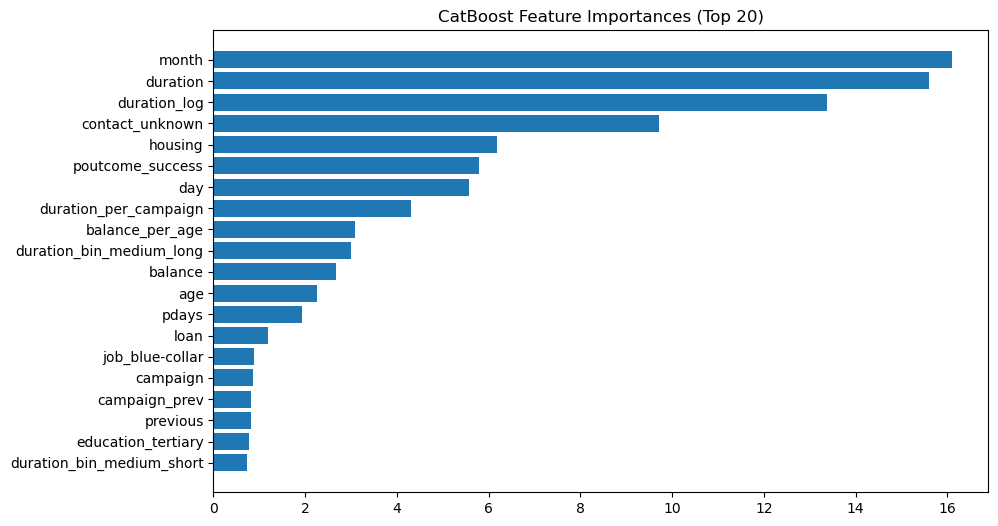

In [35]:
# Лучшая модель из GridSearch
best_cat = grids["CatBoostClassifier"].best_estimator_

# Извлекаем сам CatBoostClassifier (последний шаг пайплайна)
cat_model = best_cat.named_steps["model"]

# Восстанавливаем имена признаков после препроцессинга
# Числовые (после StandardScaler они сохраняются)
num_features = numeric_cols

# Категориальные (OneHotEncoder разворачивает в несколько dummy)
cat_features = list(
    best_cat.named_steps["preprocessor"]
    .named_transformers_["cat"]
    .get_feature_names_out(categorical_cols)
)

# Полный список признаков
all_features = num_features + list(cat_features)

# Важности
importances = cat_model.feature_importances_

# В DataFrame
feat_imp = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Показываем топ-20
display(feat_imp.head(20))

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feat_imp.head(20)["Feature"], feat_imp.head(20)["Importance"])
plt.gca().invert_yaxis()
plt.title("CatBoost Feature Importances (Top 20)")
plt.show()

- Наибольший вклад в предсказание отклика на депозит имеют месяц контакта (month, 16.1%) и длительность последнего звонка (duration, 15.6%), включая логарифмированную длительность (duration_log, 13.4%).

- Значимыми также являются способ связи (contact_unknown, 9.7%), наличие ипотеки (housing, 6.2%), успех предыдущей кампании (poutcome_success, 5.8%) и день месяца последнего контакта (day, 5.6%).

- Остальные признаки, такие как показатели кампаний, баланс, возраст и образование, оказывают умеренное влияние (1–4%), а отдельные категориальные признаки — минимальное (<1%).

Основное влияние на отклик клиентов оказывают временные параметры контакта и длительность общения, а финансовые и демографические характеристики играют второстепенную роль. Это может указывать на то, что эффективность маркетинговой кампании сильно зависит от правильного выбора времени и качества контакта с клиентом.

## Вывод

Цель проекта — предсказать, подпишется ли клиент банка на депозит.

В результате исследовательского анализа данных (EDA) обнаружили сильный дисбаланс целевой переменной: 87.93% клиентов отказались от депозита, и только 12.07% согласились. Этот дисбаланс был учтён при обучении моделей (с помощью class_weight или auto_class_weights), чтобы избежать смещения прогнозов в сторону большинства.

Анализ влияния признаков показал, что среди числовых признаков подписавшиеся клиенты чаще старшего возраста, имеют более высокий баланс и значительно большую длительность звонка. Повторные контакты и количество звонков в предыдущих кампаниях не всегда повышают вероятность отклика. Среди категориальных признаков наибольшая конверсия наблюдается у студентов и пенсионеров, холостых и клиентов с высшим образованием; наличие дефолта, ипотеки или кредита снижает вероятность согласия; наиболее результативный канал связи — мобильная связь. Дата контакта (день и месяц) и успех предыдущей кампании также оказывают сильное влияние на отклик.

Для улучшения предсказательной способности моделей был выполнен feature engineering: созданы новые признаки, связанные с длительностью звонка (логарифм, деление на количество контактов, бины), а также взаимодействия числовых признаков (balance/age, campaign * previous). Эти признаки позволили моделям лучше улавливать сложные зависимости между клиентами и их поведением.

На следующем этапе было проведено обучение моделей. Использовались три алгоритма с GridSearchCV и метрикой ROC-AUC для оценки качества: 
- Logistic Regression (0.94)
- XGBoost (0.96)
- CatBoostClassifier (0.964), который показал наилучший результат. Это подтверждает, что бустинговые методы эффективно выявляют нелинейные зависимости между признаками и откликом клиентов.

Для проверки стабильности модели CatBoostClassifier применили её к тестовым данным. Результаты на платформе Kaggle продемонстрировали высокую стабильность предсказаний: Private Score = 0.96487, Public Score = 0.96524.

Анализ важности признаков показал, что наибольшее влияние на отклик имеют месяц контакта, длительность звонка и её логарифм, способ связи, наличие ипотеки, успех предыдущей кампании и день месяца контакта. Финансовые и демографические характеристики оказывают второстепенное влияние.

Эффективность маркетинговой кампании в основном зависит от времени и качества контакта с клиентом, а не только от финансового или демографического профиля.